In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import string

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer # Uses the WordNet database to find the lemma (stem) of the words: running -> run, better -> good.
# Stemming means cutting off the end of the words
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
nltk.download("all")

In [2]:
# import warnings
# warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True) # Downloads the Open Multilingual WordNet resource needed by NLTK, and quiet=True prevents it from printing download progress/info.
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

In [3]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.columns = df.columns.str.lower()
df.columns

Index(['review', 'rating'], dtype='object')

In [5]:
df.rating.unique()

array([4, 2, 3, 5, 1])

In [6]:
df['rating'].value_counts()


rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64

We transform the Rating column to positive and negative labels (binary labels)

Ratings 1, 2, and 3 are considered as negative and ratings 4 and 5 are positive.

In [7]:
def convert_ratings(rating):
    if rating <= 3:
        return "negative"
    else:
        return "positive"

In [8]:
df['rating'] = df['rating'].apply(convert_ratings)
df.head()

,review,rating
0,nice hotel expensive parking got good deal sta...,positive
1,ok nothing special charge diamond member hilto...,negative
2,nice rooms not 4* experience hotel monaco seat...,negative
3,"unique, great stay, wonderful time hotel monac...",positive
4,"great stay great stay, went seahawk game aweso...",positive


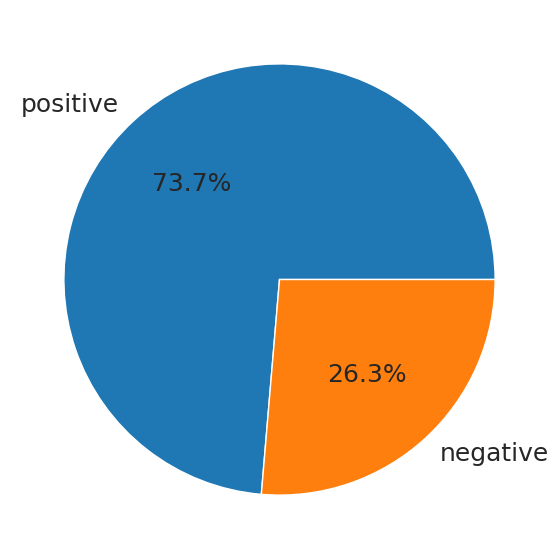

In [9]:
plt.pie(df.rating.value_counts(), labels=df.rating.unique().tolist(), autopct='%1.1f%%')
plt.show()

In [10]:
# adds a column that shows the length of the each review
df['length'] = df['review'].str.len()
df.head()

,review,rating,length
0,nice hotel expensive parking got good deal sta...,positive,593
1,ok nothing special charge diamond member hilto...,negative,1689
2,nice rooms not 4* experience hotel monaco seat...,negative,1427
3,"unique, great stay, wonderful time hotel monac...",positive,600
4,"great stay great stay, went seahawk game aweso...",positive,1281


In [11]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [12]:
# adds a column that shows the count of words in each review
df['word_count'] = df['review'].apply(word_count)
df.head()

,review,rating,length,word_count
0,nice hotel expensive parking got good deal sta...,positive,593,87
1,ok nothing special charge diamond member hilto...,negative,1689,250
2,nice rooms not 4* experience hotel monaco seat...,negative,1427,217
3,"unique, great stay, wonderful time hotel monac...",positive,600,89
4,"great stay great stay, went seahawk game aweso...",positive,1281,191


In [13]:
df.word_count.mean()

np.float64(104.37582353228247)

In [14]:
 # This function calculates the average word length in each reveiw
def mean_word_len(review):
    review_list = review.split()
    sum = 0
    for word in review_list:
        sum += len(word)
    return sum/len(review_list)

In [15]:
df['review'].apply(mean_word_len)

0        5.804598
1        5.752000
2        5.571429
3        5.730337
4        5.701571
           ...   
20486    5.715596
20487    6.820513
20488    6.015873
20489    6.113956
20490    5.877778
Name: review, Length: 20491, dtype: float64

In [16]:
# Another way of calculating the average word length:
df['mean_word_length'] = df['review'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
df.head()

,review,rating,length,word_count,mean_word_length
0,nice hotel expensive parking got good deal sta...,positive,593,87,5.804598
1,ok nothing special charge diamond member hilto...,negative,1689,250,5.752000
2,nice rooms not 4* experience hotel monaco seat...,negative,1427,217,5.571429
3,"unique, great stay, wonderful time hotel monac...",positive,600,89,5.730337
4,"great stay great stay, went seahawk game aweso...",positive,1281,191,5.701571


In [28]:
np.mean([len(sentence) for sentence in tokenize.sent_tokenize(df.review[0])])

np.float64(591.0)

In [30]:
# average length of the sentences

df['mean_sent_length'] = df.review.map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))

In [31]:
df.head()

,review,rating,length,word_count,mean_word_length,mean_sent_length
0,nice hotel expensive parking got good deal sta...,positive,593,87,5.804598,591.0
1,ok nothing special charge diamond member hilto...,negative,1689,250,5.752000,1687.0
2,nice rooms not 4* experience hotel monaco seat...,negative,1427,217,5.571429,712.0
3,"unique, great stay, wonderful time hotel monac...",positive,600,89,5.730337,598.0
4,"great stay great stay, went seahawk game aweso...",positive,1281,191,5.701571,1279.0


In [59]:
# boxplot (box and whiskers plot), shows the min, max values as the end of the whiskers.
# The median is the line in the box, the median of the first half is the lower edge of the box.
# The median of the second half is the upper edge of the box.

# kdeplot (kernel density estimate), shows the smoothed-out probability density of the data.
# It is a smoothed-out version of histogram. So instead of bins, we have a curve.

def visualize(col):
    
    plt.subplot(1,2,1)
    sns.boxplot(y=df[col], hue=df['rating'])
    plt.ylabel(col, labelpad=12.5)
    
    plt.subplot(1,2,2)
    sns.kdeplot(data=df, x=col, hue='rating')
    plt.legend(df['rating'].unique())
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()


['length', 'word_count', 'mean_word_length', 'mean_sent_length']


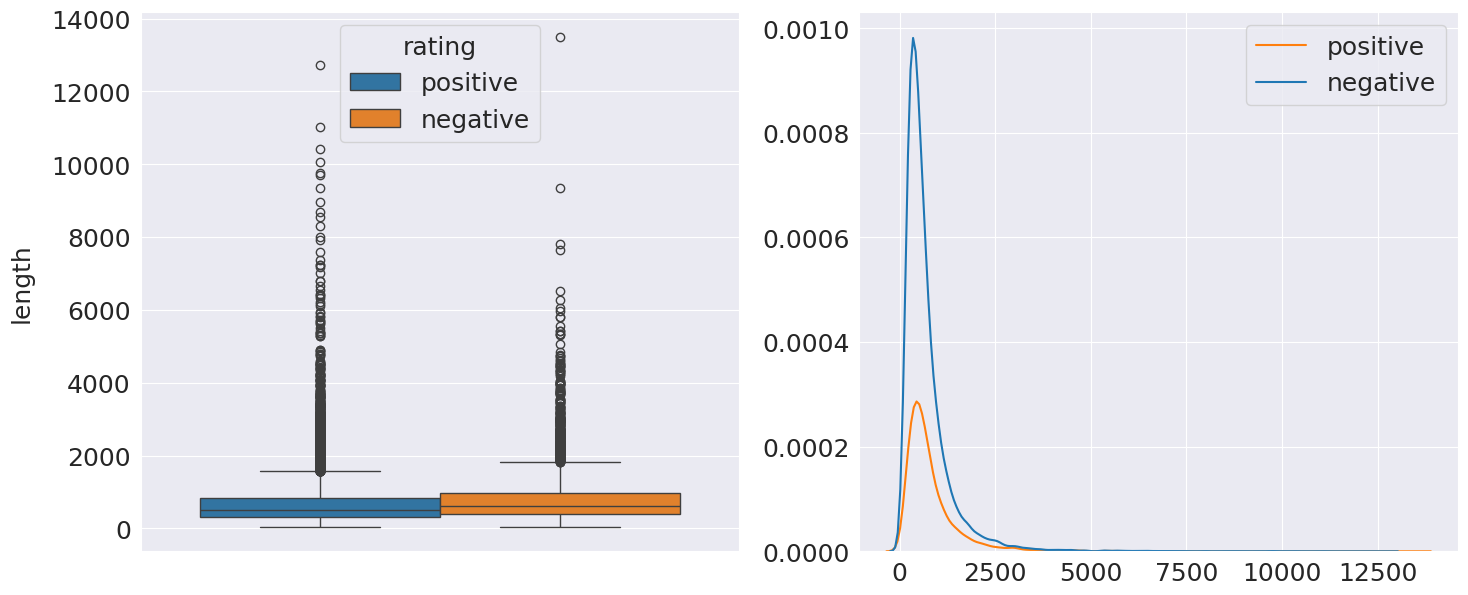

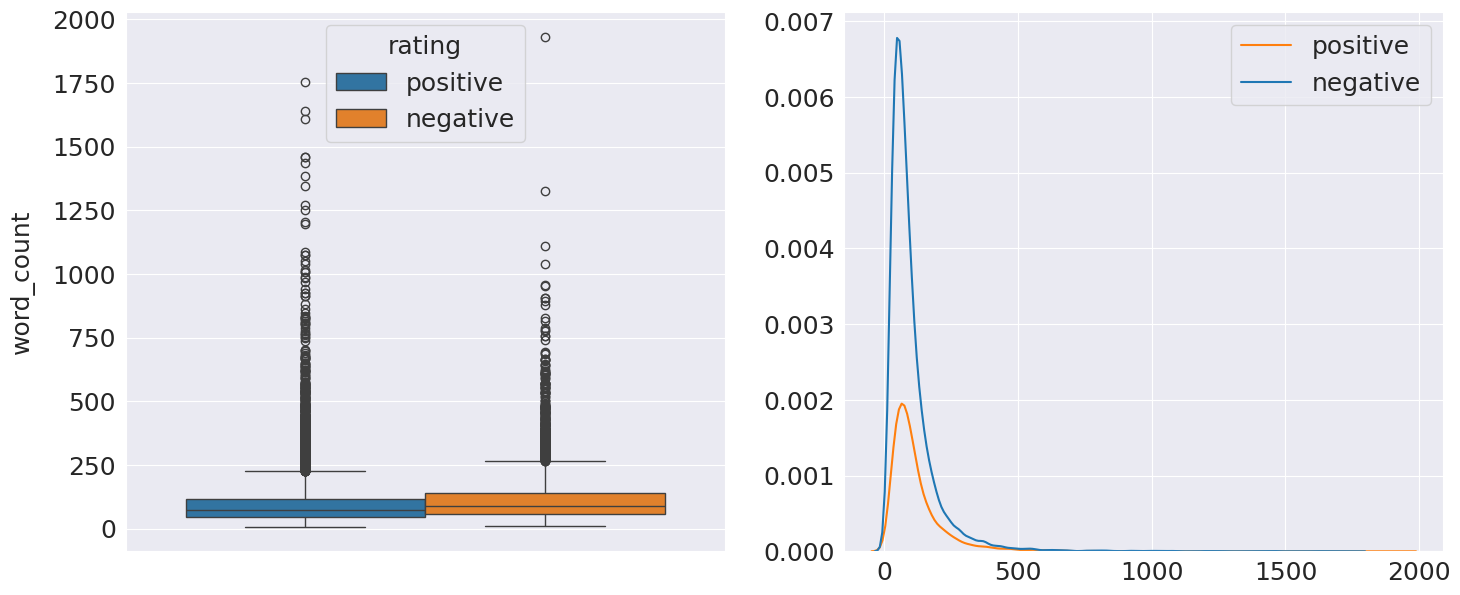

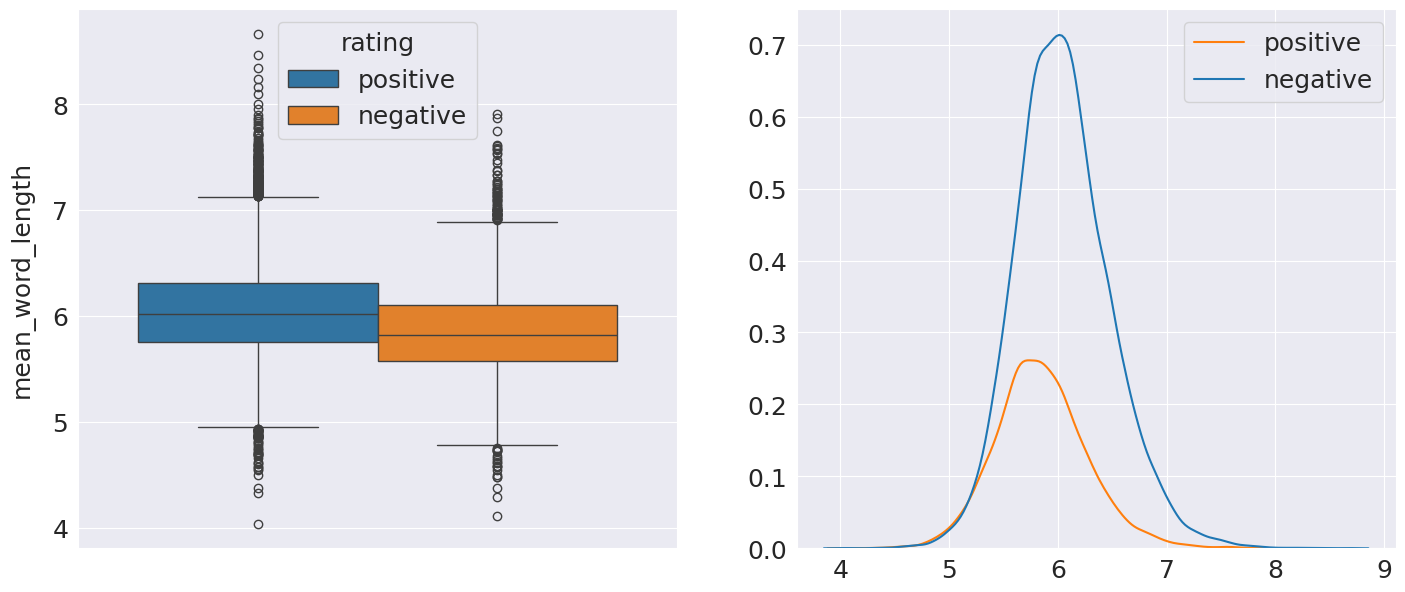

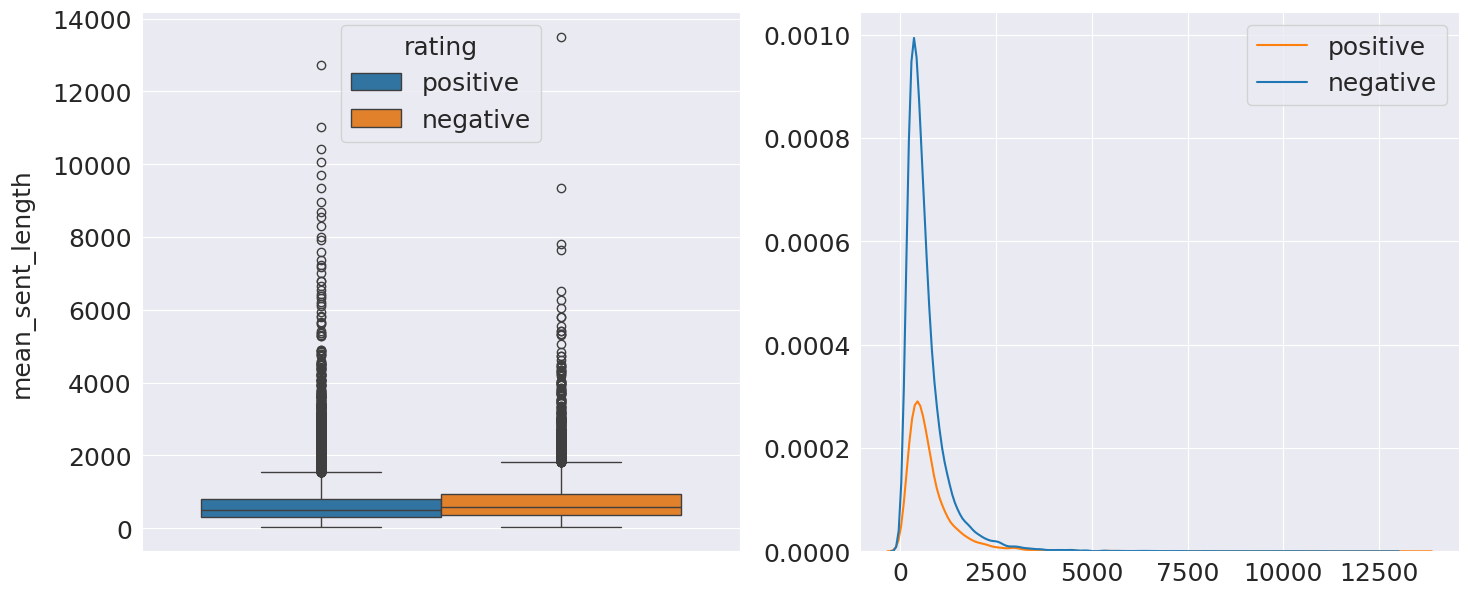

In [60]:
features = df.columns.tolist()[2:]
print(features)

for feature in features:
    visualize(feature)

In [48]:
df.isnull().sum()

review              0
rating              0
length              0
word_count          0
mean_word_length    0
mean_sent_length    0
dtype: int64

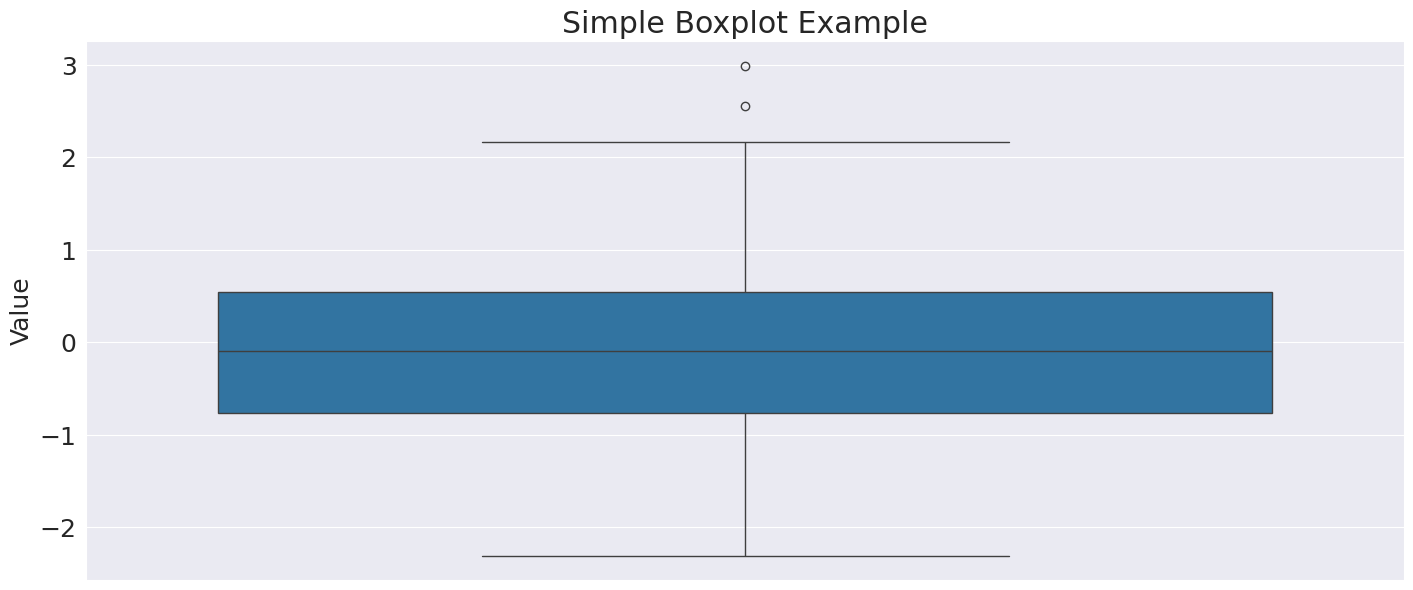

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = np.random.normal(loc=0, scale=1, size=100)

# Create boxplot
sns.boxplot(data=data)
plt.title("Simple Boxplot Example")
plt.ylabel("Value")
plt.show()
